This work is inspired by this repo: https://github.com/itberrios/CV_tracking/blob/main/kitti_tracker/

Download 2011_09_26_drive_0009 data from the KITTI dataset

In [1]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0009/2011_09_26_drive_0009_sync.zip

--2024-07-04 10:56:31--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0009/2011_09_26_drive_0009_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 3.5.135.10, 52.219.171.81, 52.219.72.175, ...
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|3.5.135.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1791264044 (1.7G) [application/zip]
Saving to: ‘2011_09_26_drive_0009_sync.zip’

2011_09_26_drive_00 100%[===================>]   1.67G  21.2MB/s    in 91s     

2024-07-04 10:58:03 (18.7 MB/s) - ‘2011_09_26_drive_0009_sync.zip’ saved [1791264044/1791264044]



In [2]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip

--2024-07-04 10:58:08--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 3.5.135.137, 52.219.171.53, 3.5.135.240, ...
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|3.5.135.137|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4068 (4.0K) [application/zip]
Saving to: ‘2011_09_26_calib.zip’

2011_09_26_calib.zi 100%[===================>]   3.97K  --.-KB/s    in 0s      

2024-07-04 10:58:09 (166 MB/s) - ‘2011_09_26_calib.zip’ saved [4068/4068]



Extract the downloaded files

In [3]:
!jar xf 2011_09_26_drive_0009_sync.zip
!jar xf 2011_09_26_calib.zip

Importing Libraries

In [6]:
import os
from glob import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
DATA_PATH = r'2011_09_26/2011_09_26_drive_0009_sync'

# get RGB camera data
left_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_02/data/*.png')))
right_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_03/data/*.png')))

# get LiDAR data
bin_paths = sorted(glob(os.path.join(DATA_PATH, 'velodyne_points/data/*.bin')))


print(f"Number of left images: {len(left_image_paths)}")
print(f"Number of right images: {len(right_image_paths)}")
print(f"Number of LiDAR point clouds: {len(bin_paths)}")

Number of left images: 447
Number of right images: 447
Number of LiDAR point clouds: 443


Loading Calibration data

In [8]:
with open('2011_09_26/calib_cam_to_cam.txt','r') as f:
    calib = f.readlines()

# get projection matrices (rectified left camera --> left camera (u,v,z))
P_rect2_cam2 = np.array([float(x) for x in calib[25].strip().split(' ')[1:]]).reshape((3,4))


# get rectified rotation matrices (left camera --> rectified left camera)
R_ref0_rect2 = np.array([float(x) for x in calib[24].strip().split(' ')[1:]]).reshape((3, 3,))

# add (0,0,0) translation and convert to homogeneous coordinates
R_ref0_rect2 = np.insert(R_ref0_rect2, 3, values=[0,0,0], axis=0)
R_ref0_rect2 = np.insert(R_ref0_rect2, 3, values=[0,0,0,1], axis=1)


# get rigid transformation from Camera 0 (ref) to Camera 2
R_2 = np.array([float(x) for x in calib[21].strip().split(' ')[1:]]).reshape((3,3))
t_2 = np.array([float(x) for x in calib[22].strip().split(' ')[1:]]).reshape((3,1))

# get cam0 to cam2 rigid body transformation in homogeneous coordinates
T_ref0_ref2 = np.insert(np.hstack((R_2, t_2)), 3, values=[0,0,0,1], axis=0)

# Load LiDAR Calibration Data
with open('2011_09_26/calib_velo_to_cam.txt', 'r') as f:
        calib = f.readlines()

R = np.array([float(x) for x in calib[1].strip().split(' ')[1:]]).reshape((3, 3))
t = np.array([float(x) for x in calib[2].strip().split(' ')[1:]])[:, None]

T_velo_ref0 = np.vstack((np.hstack((R, t)), np.array([0, 0, 0, 1])))

In [9]:
# transform from velo (LiDAR) to left color camera (shape 3x4)
T_velo_cam2 = P_rect2_cam2 @ R_ref0_rect2 @ T_ref0_ref2 @ T_velo_ref0

# homogeneous transform from left color camera to velo (LiDAR) (shape: 4x4)
T_cam2_velo = np.linalg.inv(np.insert(T_velo_cam2, 3, values=[0,0,0,1], axis=0))

Installing YOLO

In [8]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 16725, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (196/196), done.
remote: Total 16725 (delta 139), reused 148 (delta 70), pack-reused 16459
Receiving objects: 100% (16725/16725), 15.40 MiB | 25.18 MiB/s, done.
Resolving deltas: 100% (11438/11438), done.


In [9]:
!pip install -r yolov5/requirements.txt  #Install whatever is needed

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 40.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.7/793.7 kB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (

In [1]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5m, yolov5l, yolov5x, custom

/usr/local/lib/python3.10/dist-packages/torch/hub.py:293: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
YOLOv5 🚀 2024-7-4 Python-3.10.12 torch-2.3.0+cu121 CPU

100%|██████████| 14.1M/14.1M [00:00<00:00, 214MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [2]:
# set confidence and IOU thresholds
model.conf = 0.25  # confidence threshold (0-1), default: 0.25
model.iou = 0.25  # NMS IoU threshold (0-1), default: 0.45

In [3]:
def get_uvz_centers(image, velo_uvz, bboxes, draw=True):
    ''' Obtains detected object centers projected to uvz camera coordinates.
        Starts by associating LiDAR uvz coordinates to detected object centers,
        once a match is found, the coordiantes are transformed to the uvz
        camera reference and added to the bboxes array.

        NOTE: The image is modified in place so there is no need to return it.

        Inputs:
          image - input image for detection
          velo_uvz - LiDAR coordinates projected to camera reference
          bboxes - xyxy bounding boxes form detections from yolov5 model output
          draw - (_Bool) draw measured depths on image
        Outputs:
          bboxes_out - modified array containing the object centers projected
                       to uvz image coordinates
        '''

    # unpack LiDAR camera coordinates
    u, v, z = velo_uvz

    # get new output
    bboxes_out = np.zeros((bboxes.shape[0], bboxes.shape[1] + 3))
    bboxes_out[:, :bboxes.shape[1]] = bboxes

    # iterate through all detected bounding boxes
    for i, bbox in enumerate(bboxes):
        pt1 = torch.round(bbox[0:2]).to(torch.int).numpy()
        pt2 = torch.round(bbox[2:4]).to(torch.int).numpy()

        # get center location of the object on the image
        obj_x_center = (pt1[1] + pt2[1]) / 2
        obj_y_center = (pt1[0] + pt2[0]) / 2

        # now get the closest LiDAR points to the center
        center_delta = np.abs(np.array((v, u))
                              - np.array([[obj_x_center, obj_y_center]]).T)

        # choose coordinate pair with the smallest L2 norm
        min_loc = np.argmin(np.linalg.norm(center_delta, axis=0))

        # get LiDAR location in image/camera space
        velo_depth = z[min_loc]; # LiDAR depth in camera space
        uvz_location = np.array([u[min_loc], v[min_loc], velo_depth])

        # add velo projections (u, v, z) to bboxes_out
        bboxes_out[i, -3:] = uvz_location

        # draw depth on image at center of each bounding box
        # This is depth as perceived by the camera
        if draw:
            object_center = (np.round(obj_y_center).astype(int),
                             np.round(obj_x_center).astype(int))
            cv2.putText(image,
                        '{0:.2f} m'.format(velo_depth),
                        object_center, # top left
                        cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, # font scale
                        (255, 0, 0), 2, cv2.LINE_AA)

    return bboxes_out

In [4]:
from sklearn import linear_model
def get_detection_coordinates(image, bin_path, draw_boxes=True, draw_depth=True):
    ''' Obtains detections for the input image, along with the coordinates of
        the detected object centers. The coordinate obtained are:
            - Camera with depth --> uvz
            - LiDAR/velo --> xyz
        Inputs:
            image - rgb image to run detection on
            bin_path - path to LiDAR bin file
        Output:
            bboxes - array of detected bounding boxes, confidences, classes,
            velo_uv - LiDAR points porjected to camera uvz coordinate frame
            coordinates - array of all object center coordinates in the frames
                          listed above
        '''
    ## 1. compute detections in the left image
    detections = model(image)

    # draw boxes on image
    if draw_boxes:
        detections.show()

    # get bounding box locations (x1,y1), (x2,y2) Prob, class
    bboxes = detections.xyxy[0].cpu() # remove from GPU

    # get LiDAR points and transform them to image/camera space
    # velo_uvz = project_velobin2uvz(bin_path,
    #                                T_velo_cam2,
    #                                image,
    #                                remove_plane=True)
    T_uvz_velo = T_velo_cam2
    # get homogeneous LiDAR points from bin file
    # xyzw = bin2xyzw(bin_path, remove_plane)
    remove_plane=False
    # read in LiDAR data
    scan_data = np.fromfile(bin_path, dtype=np.float32).reshape((-1,4))

    # get x,y,z LiDAR points (x, y, z) --> (front, left, up)
    xyz = scan_data[:, 0:3]

    # delete negative liDAR points
    xyz = np.delete(xyz, np.where(xyz[3, :] < 0), axis=1)

    # use ransac to remove ground plane
    if remove_plane:
        ransac = linear_model.RANSACRegressor(
                                      linear_model.LinearRegression(),
                                      residual_threshold=0.1,
                                      max_trials=5000
                                      )

        X = xyz[:, :2]
        y = xyz[:, -1]
        ransac.fit(X, y)

        # remove outlier points (i.e. remove ground plane)
        mask = ransac.inlier_mask_
        xyz = xyz[~mask]

    # conver to homogeneous LiDAR points
    xyzw = np.insert(xyz, 3, 1, axis=1).T

    # project velo (x, z, y, w) onto camera (u, v, z) coordinates
    # velo_uvz = xyzw2camera(xyzw, T_uvz_velo, image, remove_outliers=True)
    remove_outliers=True
    # convert to (left) camera coordinates
    camera =  T_uvz_velo @ xyzw

    # delete negative camera points
    camera  = np.delete(camera , np.where(camera [2,:] < 0)[0], axis=1)

    # get camera coordinates u,v,z
    camera[:2] /= camera[2, :]

    # remove outliers (points outside of the image frame)
    if remove_outliers:
        u, v, z = camera
        img_h, img_w, _ = image.shape
        u_out = np.logical_or(u < 0, u > img_w)
        v_out = np.logical_or(v < 0, v > img_h)
        outlier = np.logical_or(u_out, v_out)
        camera = np.delete(camera, np.where(outlier), axis=1)

    velo_uvz = camera

    # get uvz centers for detected objects
    bboxes = get_uvz_centers(image,
                             velo_uvz,
                             bboxes,
                             draw=draw_depth)

    return bboxes, velo_uvz

Test

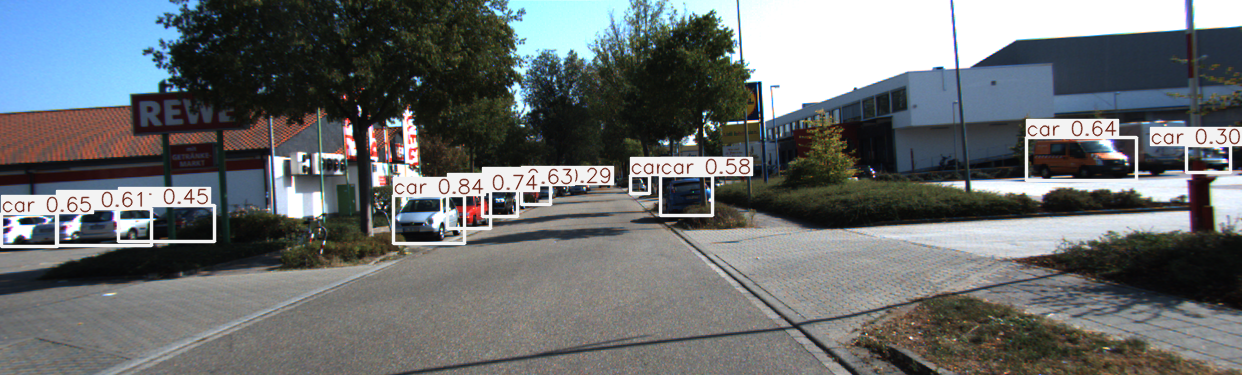

In [32]:
index = 20

left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
bin_path = bin_paths[index]

# get detections and object centers in uvz
bboxes, velo_uvz = get_detection_coordinates(left_image, bin_path)

# get transformed coordinates of object centers
uvz = bboxes[:, -3:]

In [33]:
# get color map function
rainbow_r = plt.get_cmap('rainbow_r', lut=100)
color_map = lambda z : [255*val for val in rainbow_r(int(z.round()))[:3]]

velo_image =  np.zeros_like(left_image)

u, v, z = velo_uvz

# draw LiDAR point cloud on blank image
for i in range(len(u)):
  cv2.circle(velo_image, (int(u[i]), int(v[i])), 1, color_map(z[i]), -1);

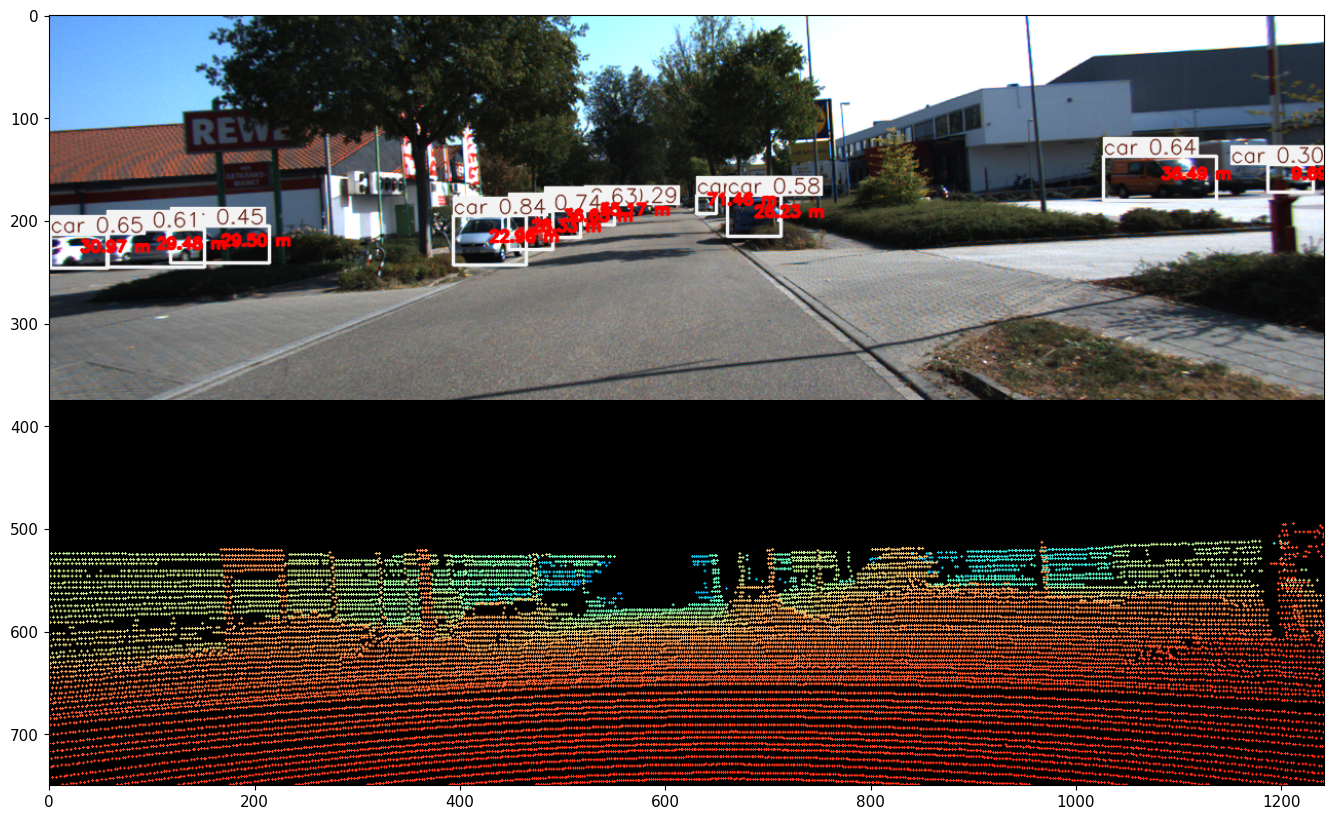

In [34]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

# stack image with LiDAR point cloud
stacked = np.vstack((left_image, velo_image))

# display stacked iamge
plt.imshow(stacked)